# Deriving the MRS spectral response for a nominal (i.e. not crossed) dichroic configuration

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [3]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'notebooks/distortionMaps/'
dichroicDir   = workDir+'MRSWaveCal/MrsFilterTransmissions/'
MTSDir        = workDir+'notebooks/pyMTSSim/OUTPUT/'
lvl2path      = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}
xpos      = {}

for band in bands:
    print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band,d2cMaps)
    ypos,xpos[band] = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2 +1,alpha_pos=0.)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


In [4]:
# Populate dictionaries with maps of L_sky
L_skyMap = {}
for BBTemp in ["400K", "600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    L_skyMap[BBTemp] = {}   
    tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky" + BBTemp + ".fits" )[1]
    ip_Lsky = interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"], kind='cubic')
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        L_skyMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)
        waves = np.reshape(lambdaMap[band][sel], -1)
        L_skyMap[BBTemp][band][sel] = ip_Lsky(waves)*1000. #mJy/arcsec^2

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [5]:
# Populate dictionaries with maps of E_pix
# Calculate the spectral irradiance E_pix : [mJy/pixel]
# E_pix = omega_pix * L_pix
E_pixMap = {}
for BBTemp in ["400K", "600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    E_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        E_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)
        E_pixMap[BBTemp][band][sel] = sizeMap[band][sel] * L_skyMap[BBTemp][band][sel]

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [6]:
hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,'1A',bb_temp='400K',corr1='_skip1firstframes',output='filename')[0])
print 'Frame number to start slope fit: {}'.format(hdulist[0].header['NSFITS'])
print 'Frame number to end slope fit: {}'.format(hdulist[0].header['NSFITE'])
if hdulist[0].header['USE_LIN'] == 'Yes':
    print 'Linearity Correction: {}'.format(hdulist[0].header['LIN'])
else:
    print 'No linearity correction'
print ''
hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,'1A',bb_temp='400K',corr1='_skip2firstframes',output='filename')[0])
print 'Frame number to start slope fit: {}'.format(hdulist[0].header['NSFITS'])
print 'Frame number to end slope fit: {}'.format(hdulist[0].header['NSFITE'])
if hdulist[0].header['USE_LIN'] == 'Yes':
    print 'Linearity Correction: {}'.format(hdulist[0].header['LIN'])
else:
    print 'No linearity correction'
print ''
hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,'1A',bb_temp='400K',corr1='_noLinearity',output='filename')[0])
print 'Frame number to start slope fit: {}'.format(hdulist[0].header['NSFITS'])
print 'Frame number to end slope fit: {}'.format(hdulist[0].header['NSFITE'])
if hdulist[0].header['USE_LIN'] == 'Yes':
    print 'Linearity Correction: {}'.format(hdulist[0].header['LIN'])
else:
    print 'No linearity correction'

Frame number to start slope fit: 2
Frame number to end slope fit: 19
No linearity correction

Frame number to start slope fit: 3
Frame number to end slope fit: 19
Linearity Correction: MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00.fits

Frame number to start slope fit: 3
Frame number to end slope fit: 19
No linearity correction


In [7]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

#-- Uncomment to re-run
S_pixMap = {}
dS_pixMap = {}
BadPixelMap ={}
for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    S_pixMap[BBTemp] = {}
    dS_pixMap[BBTemp] = {}
    BadPixelMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        print "Band {}".format(band)
        S_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dS_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        BadPixelMap[BBTemp][band] = np.full( validMap[band].shape, 0 )
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,corr1='_skip1firstframes',output='filename')[0])
        slopeHOLE = hdulist[0].data[0,:,:]
        dslopeHOLE = hdulist[0].data[1,:,:]
        maskHOLE = hdulist[0].data[2,:,:]
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,corr1='_skip1firstframes',output='filename')[1])
        slopeBLANK = hdulist[0].data[0,:,:]
        dslopeBLANK = hdulist[0].data[1,:,:]
        maskBLANK = hdulist[0].data[2,:,:]
        sel = (validMap[band]==1) & (maskHOLE==0) & (maskBLANK==0)
        S_pixMap[BBTemp][band][sel] = slopeHOLE[sel] - slopeBLANK[sel]
        dS_pixMap[BBTemp][band][sel] = np.sqrt(dslopeHOLE[sel]**2 + dslopeBLANK[sel]**2)
        BadPixelMap[BBTemp][band][(validMap[band]==1) & (maskHOLE>0) & (maskBLANK>0)] = 1

BBTemp 400K
Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
BBTemp 600K
Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
BBTemp 800K
Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


In [8]:
# Populate dictionaries with maps of R_pix [DN/sec/mJy/pixel] and dR_pix 
# 
        
R_pixMap = {}
dR_pixMap = {}

for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    R_pixMap[BBTemp] = {}
    dR_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        fringe_img = funcs.get_cdps(band,cdpDir)[0]
        R_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dR_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)& (BadPixelMap[BBTemp][band]==0)
        R_pixMap[BBTemp][band][sel] = (S_pixMap[BBTemp][band][sel] / E_pixMap[BBTemp][band][sel])/fringe_img[sel]
        dR_pixMap[BBTemp][band][sel] = R_pixMap[BBTemp][band][sel] * dS_pixMap[BBTemp][band][sel]/S_pixMap[BBTemp][band][sel]

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [9]:
# Populate dictionaries with maps of PHOTOM_pix [DN/sec/mJy/pixel] (from the MRS PHOTOM CDP)
# 

PHOTOM_pixMap = {}

for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    PHOTOM_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        photom_img = funcs.get_cdps(band,cdpDir)[1]
        PHOTOM_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)& (BadPixelMap[BBTemp][band]==0)
        PHOTOM_pixMap[BBTemp][band][sel] = photom_img[sel]

BBTemp 400K
BBTemp 600K
BBTemp 800K


<IPython.core.display.Javascript object>


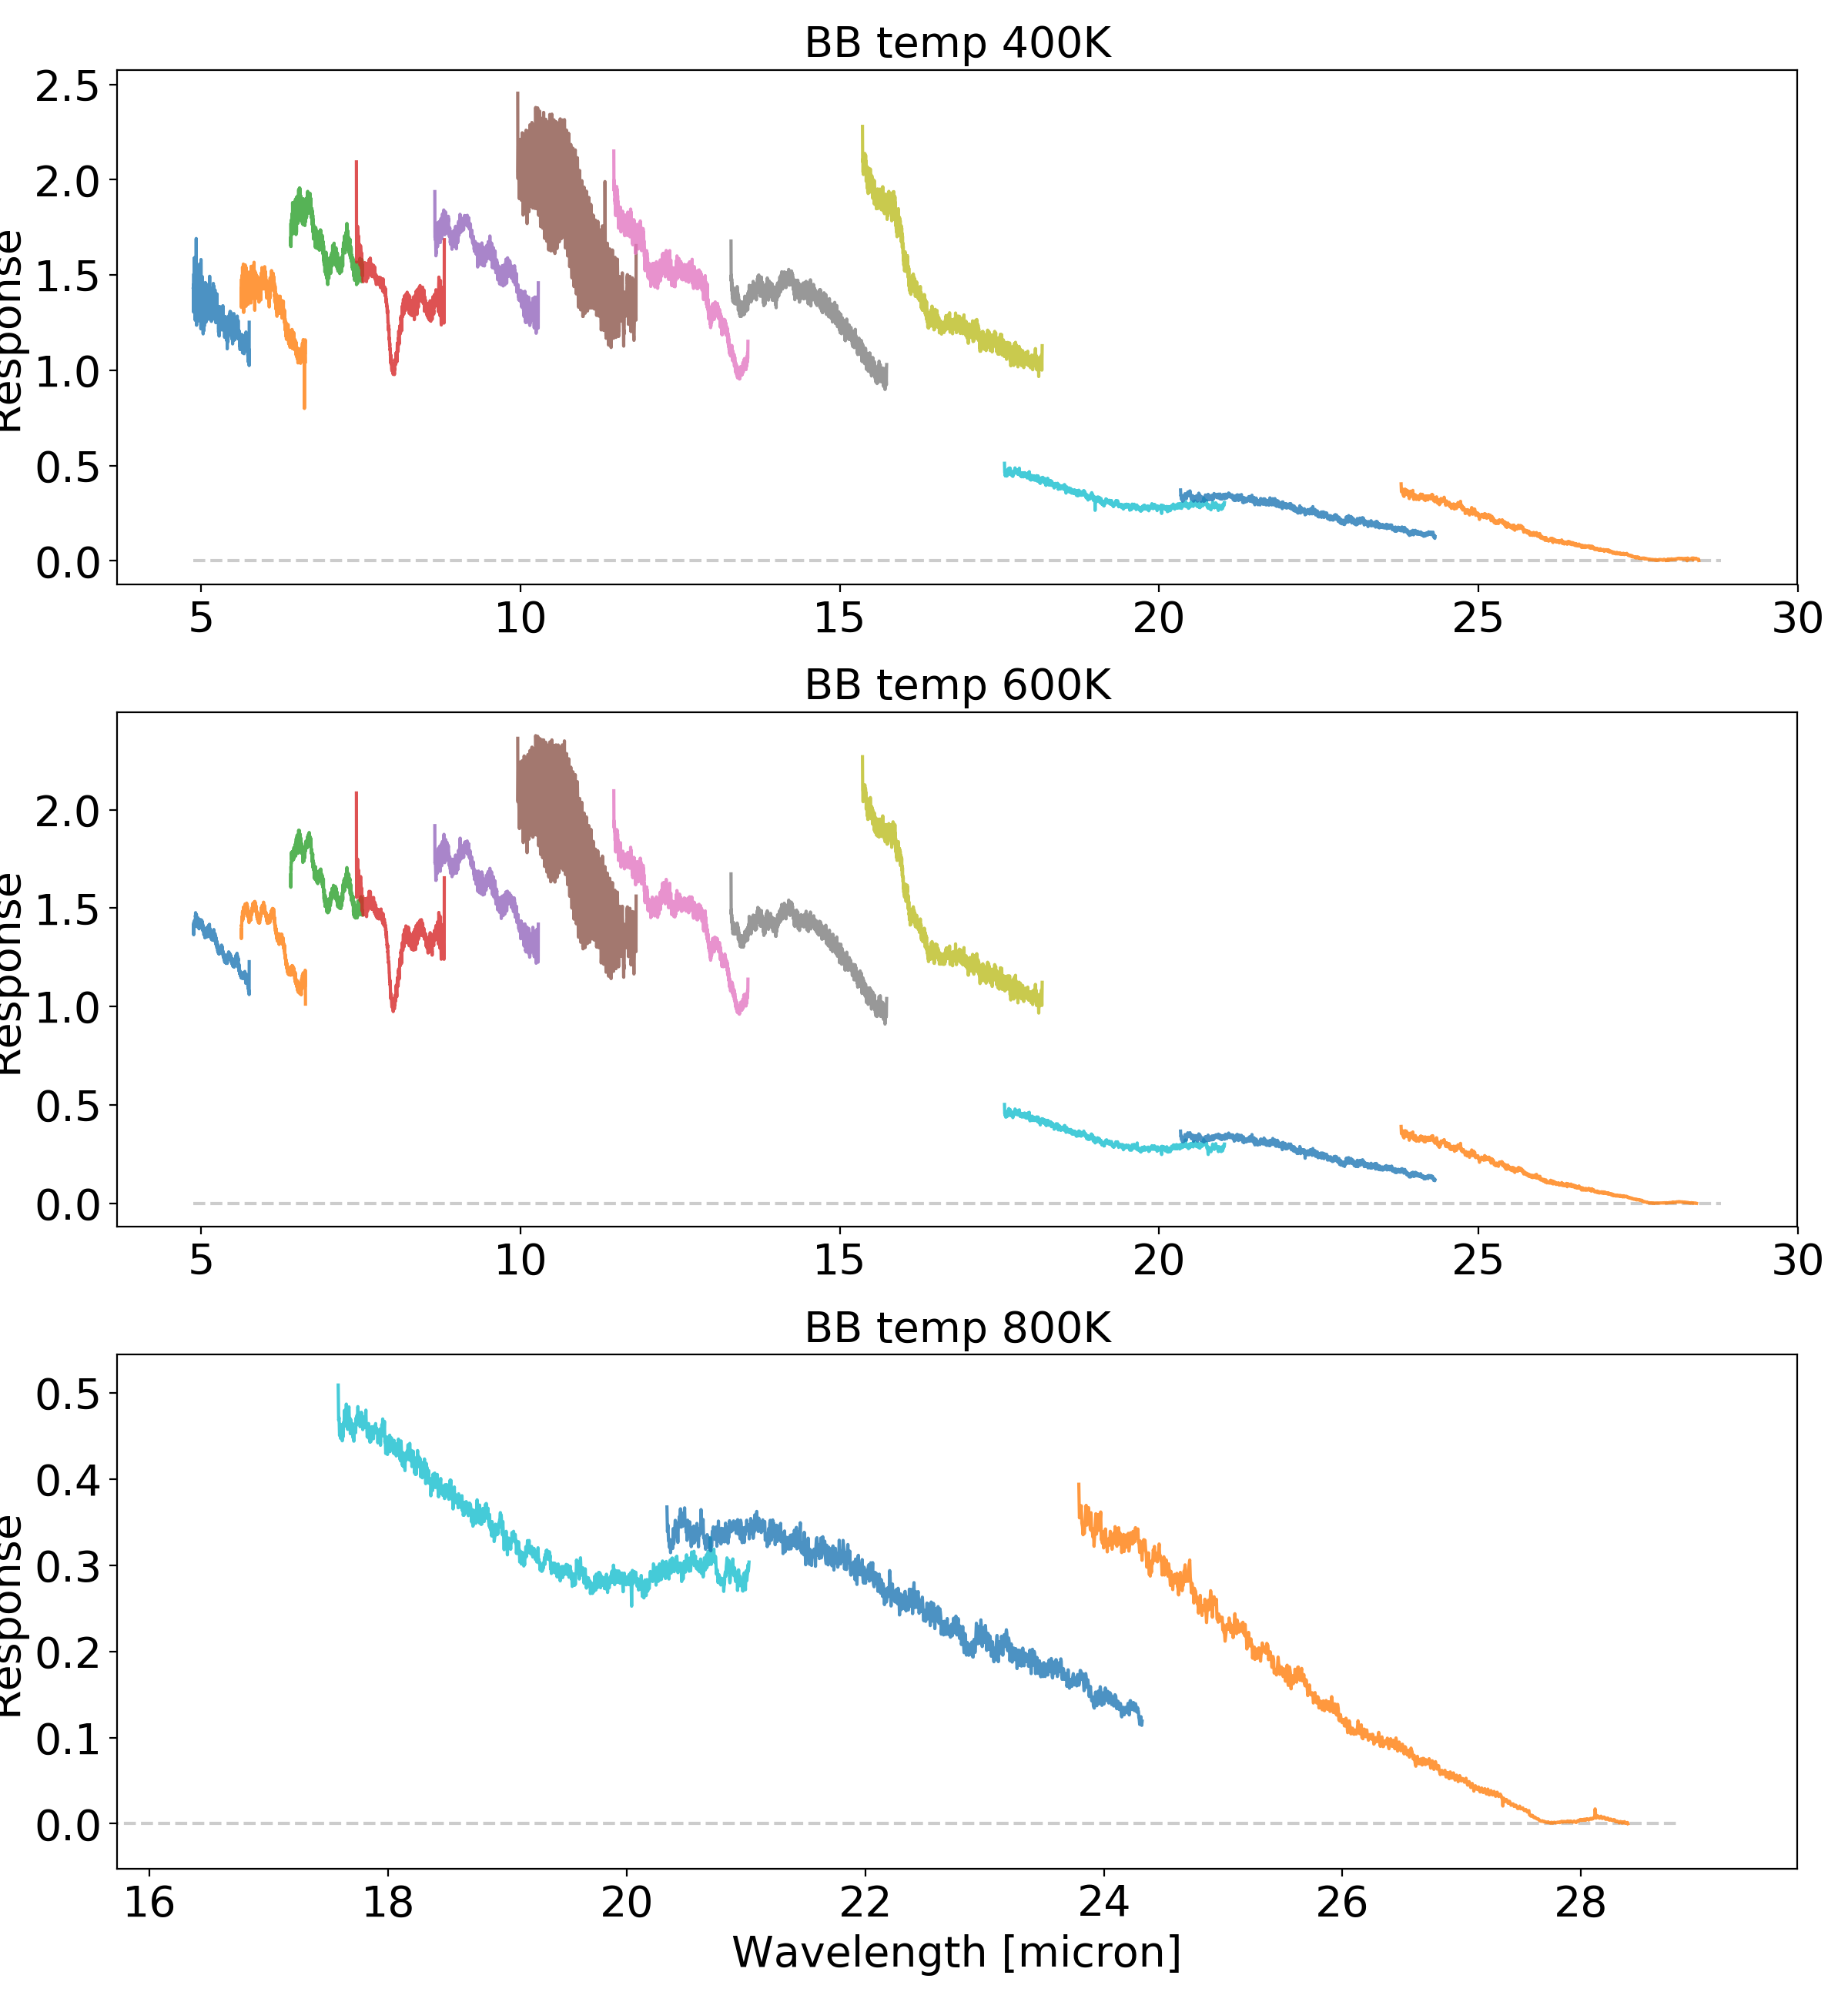

In [10]:
fig,axs = plt.subplots(3,1,figsize=(12,13))
plot = -1
for BBTemp in ["400K","600K", "800K"]:
    plot +=1
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        sel = R_pixMap[BBTemp][band][ypos,xpos[band]]> 0.
#         axs[plot].plot(lambdaMap[band][ypos,xpos[band]],PHOTOM_pixMap[BBTemp][band][ypos,xpos[band]],'b')
        axs[plot].plot(lambdaMap[band][ypos,xpos[band]][sel],R_pixMap[BBTemp][band][ypos,xpos[band]][sel],alpha=0.8)
    axs[plot].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
#     legend_elements = [Line2D([0],[0],color='b',label='DHAS 9.1.4'),Line2D([0],[0],color='orange',alpha=0.8,label='DHAS 9.4.4')]
#     axs[plot].legend(handles=legend_elements)
    axs[plot].set_title("BB temp {}".format(BBTemp))
    axs[plot].set_ylabel('Response') # [DN sec^-1 mJy^-1 pixel]
axs[2].set_xlabel('Wavelength [micron]')
plt.tight_layout()

<IPython.core.display.Javascript object>


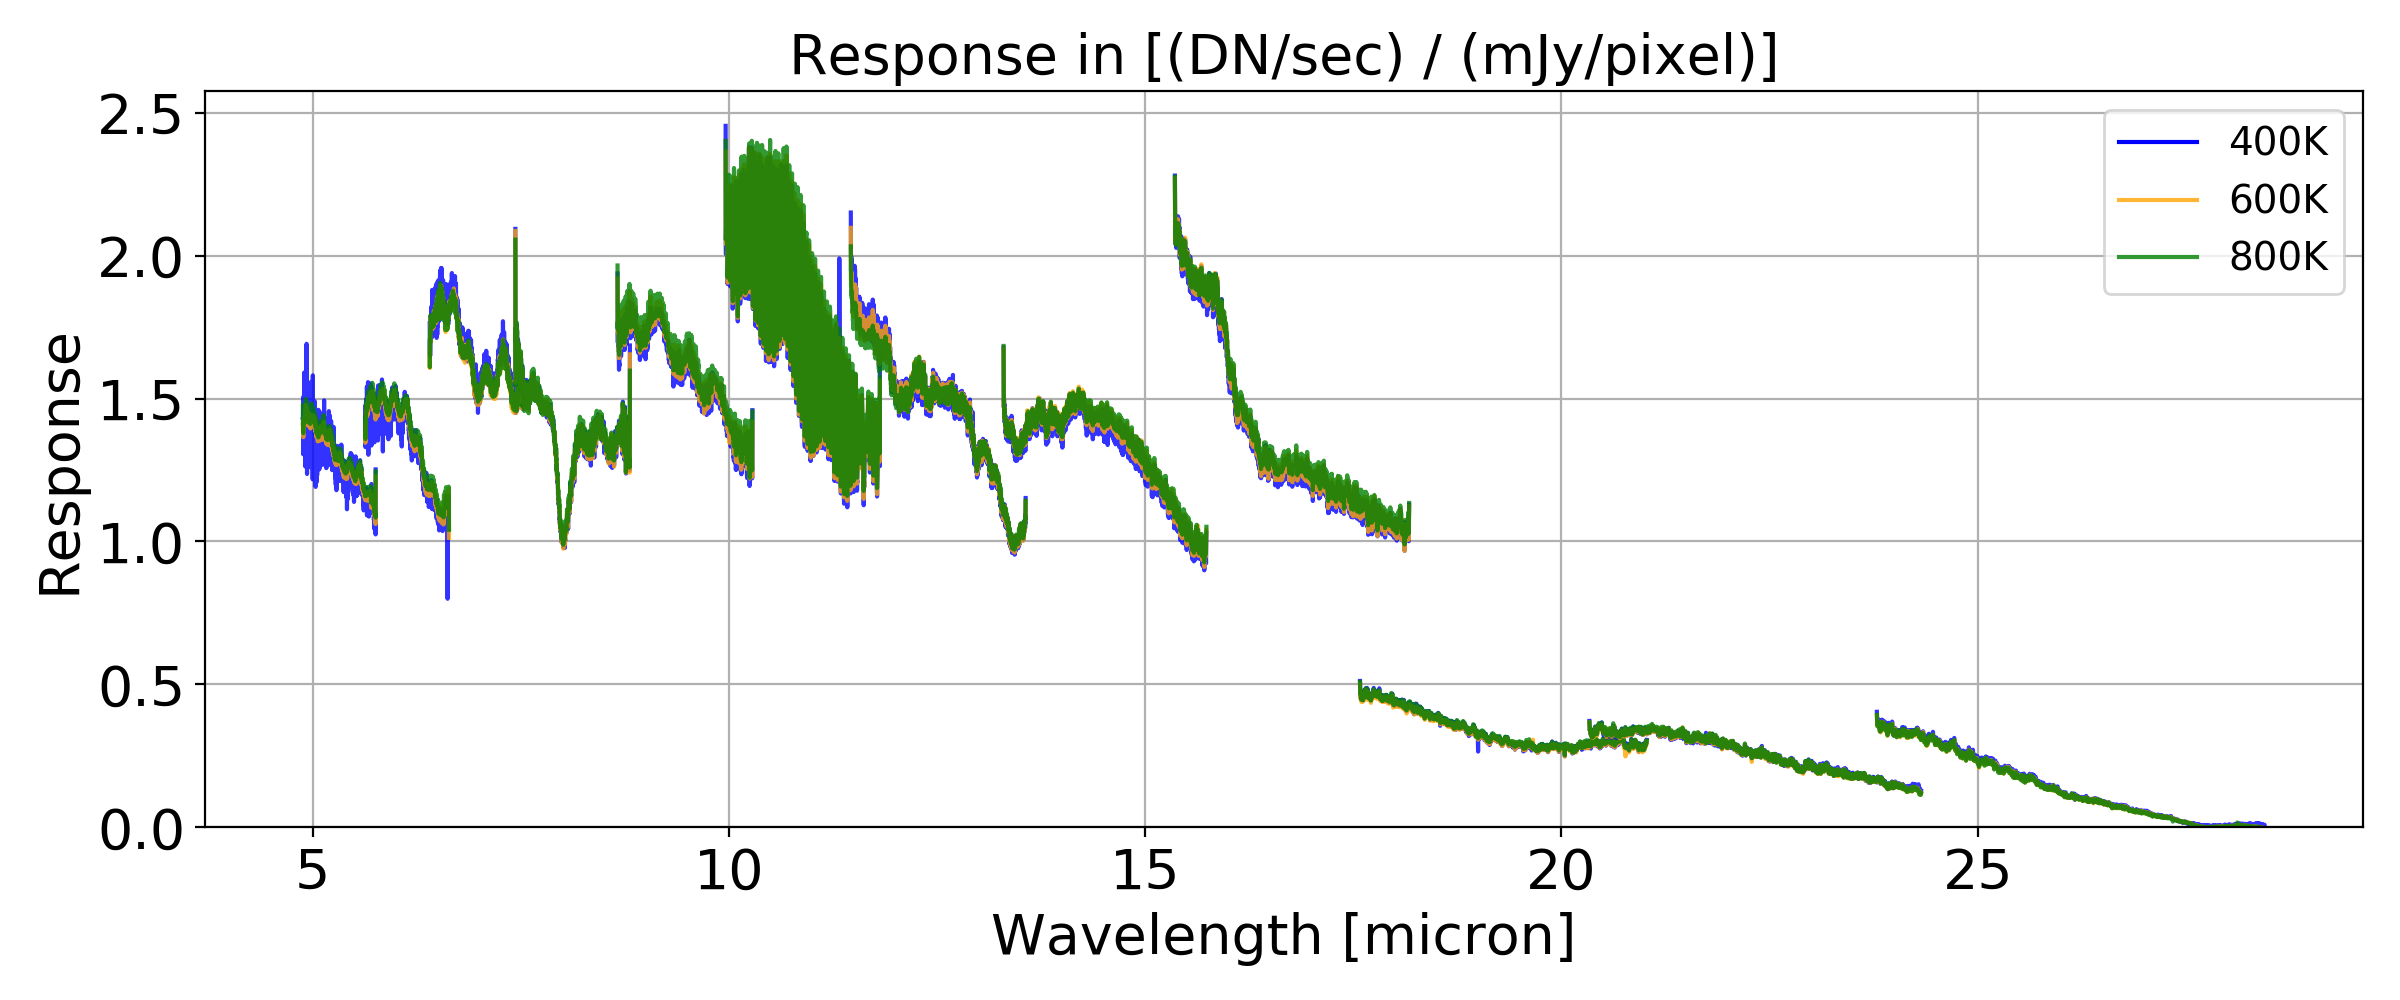

In [12]:
plt.figure(figsize=(12,5))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    plt.plot(lambdaMap[band][ypos,xpos[band]],R_pixMap['400K'][band][ypos,xpos[band]],'b',alpha=0.8)
    plt.plot(lambdaMap[band][ypos,xpos[band]],R_pixMap['600K'][band][ypos,xpos[band]],'orange',alpha=0.8)
    plt.plot(lambdaMap[band][ypos,xpos[band]],R_pixMap['800K'][band][ypos,xpos[band]],'g',alpha=0.8)
plt.ylim(0)
legend_elements = [Line2D([0],[0],color='b',label='400K'),Line2D([0],[0],color='orange',alpha=0.8,label='600K'),Line2D([0],[0],color='g',alpha=0.8,label='800K')]
plt.legend(handles=legend_elements,loc='upper right')
plt.title("Response in [(DN/sec) / (mJy/pixel)]")
plt.ylabel('Response') # [DN sec^-1 mJy^-1 pixel]
plt.xlabel('Wavelength [micron]')
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


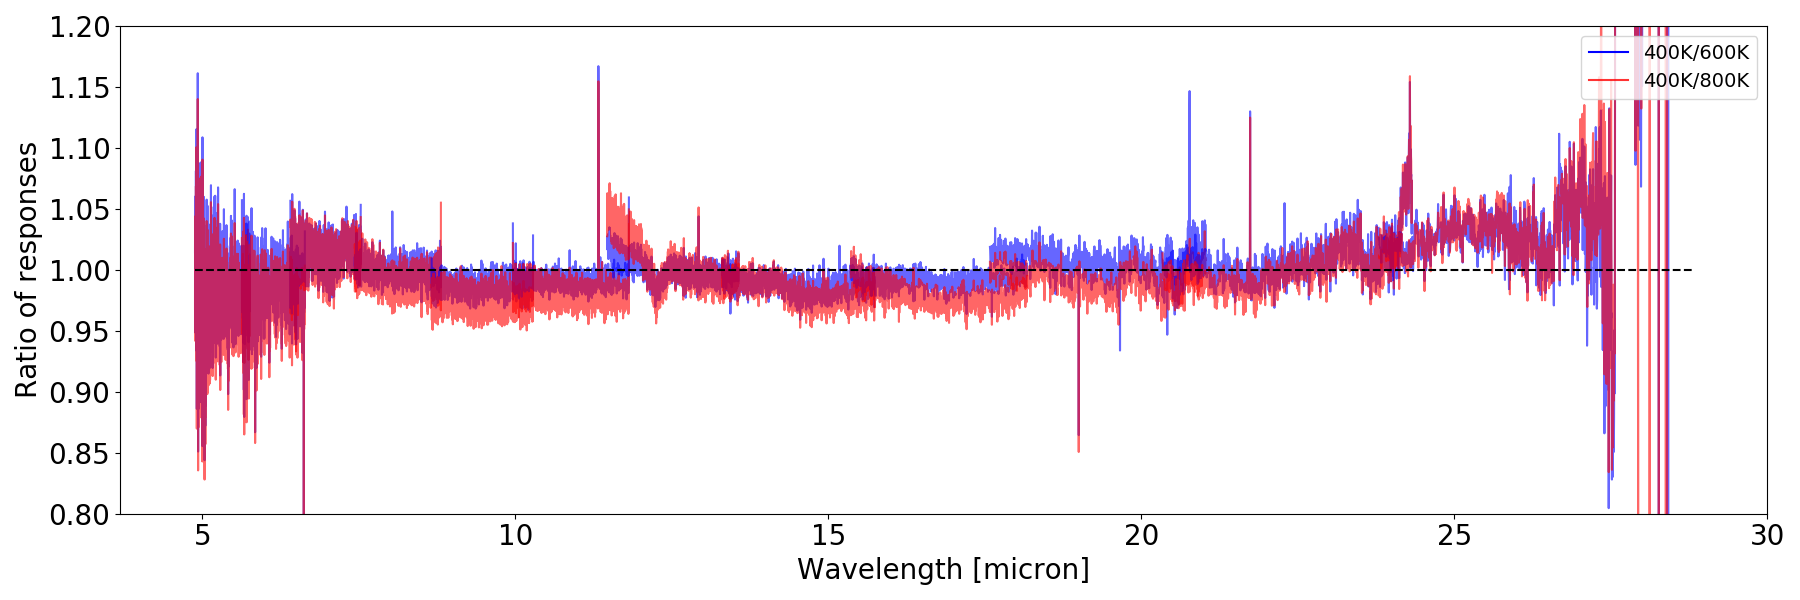

In [39]:
plt.figure(figsize=(18,6))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    plt.plot(lambdaMap[band][ypos,xpos[band]],R_pixMap['400K'][band][ypos,xpos[band]]/R_pixMap['600K'][band][ypos,xpos[band]],'b',alpha=0.6,zorder=0)
    plt.plot(lambdaMap[band][ypos,xpos[band]],R_pixMap['400K'][band][ypos,xpos[band]]/R_pixMap['800K'][band][ypos,xpos[band]],'r',alpha=0.6,zorder=0)
plt.hlines(1,4.88,28.8,'k',linestyle='dashed',zorder=1)
plt.ylim(0.8,1.2)
legend_elements = [Line2D([0],[0],color='b',label='400K/600K'),Line2D([0],[0],color='r',alpha=0.8,label='400K/800K')]
plt.legend(handles=legend_elements,loc='upper right')
plt.ylabel('Ratio of responses')
plt.xlabel('Wavelength [micron]')
plt.tight_layout()

# Conclusions
When using DHAS 9.1.4, PHOTOM was derived using data that were reduced with miri_sloper using the following CDP files:
    * MIRI_FM_MIRIFUSHORT_12_MASK_06.02.00
    * MIRI_FM_MIRIFUSHORT_12_RSCD_05.00.00
    * MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_06.02.00
When using DHAS 9.4.4, the "new" response was derived using data that were reduced using the following CDP files:
    * MIRI_FM_MIRIFUSHORT_12_MASK_06.02.00
    * MIRI_FM_RAL_MIRIFUSHORT_12_SATURATION_07.02.00
    * MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00

The PHOTOM CDP was derived based on the MTS 800K BB extended source data. As such the better match between PHOTOM and the "new" response is expected to occur for the 800K BB case. That being said, we see some small differences in the 800K BB plot, which are due to the differences in the linearity correction CDP used and the application of the RSCD CDP in the case of the PHOTOM CDP derivation.